# Job Posting Analysis
Looking at job postings to identify the differences between _Data Scientists_ and _Data Engineers_

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

In [2]:
# !cd data/
# !kaggle competitions download -c job-salary-prediction
# !unzip job-salary-prediction.zip -d job_salary
# !cd ../
# !ls -al data/job_salary/

## Download Data
We will be using datasets from [Kaggle Datasets](https://www.kaggle.com/datasets) since they are well formatted.  Starting with a dataset associated with a [_Job Salary Prediction_](https://www.kaggle.com/c/job-salary-prediction) competition

In [4]:
datapath = os.path.join(os.path.abspath('.'),'data')
jobs = pd.read_csv(os.path.join(datapath,'job_salary/Valid_rev1.csv'))
jobs.head(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName
0,13656201,"Lead Technical Architect, C Banking",Lead Technical Architect required for a Tier *...,London,London,NaN,permanent,Scope AT Limited,IT Jobs,jobserve.com
1,14663195,RECRUITMENT CONSULTANT INDUSTRIAL / COMMERCIA...,THIS IS A LIVE VACANCY NOT A GENERIC ADVERTISE...,"LEEDS, West Yorkshire",Leeds,NaN,permanent,Code Blue Recruitment,HR & Recruitment Jobs,cv-library.co.uk
2,16530664,Mechanical / Chemical / Process Engineer Cool...,Mechanical / Chemical / Process Engineer Cool...,"Hampshire, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,cv-library.co.uk


In [5]:
# Build function to tag data engineer and data scientist job postings
def DataTag(Title):
    if 'data' in Title:
        if 'engineer' in Title:
            return 'de'
        elif 'scientist' in Title:
            return 'ds'
        else:
            return np.nan
    else:
        return np.nan

jobs = jobs.applymap(lambda x:x.lower() if type(x) == str else x) # lower case to all text fields
jobs['tag'] = jobs['Title'].apply(DataTag)
data_jobs = jobs[jobs['tag'].notnull()].reset_index(drop=True)
# data_jobs.head(3)
print('Total DS jobs:\t{}\nTotal DE jobs:\t{}'\
    .format(len(data_jobs[data_jobs['tag']=='ds']), 
    len(data_jobs[data_jobs['tag']=='de'])))

Total DS jobs:	3
Total DE jobs:	26


The job salary prediction dataset was >7 years old, and lacking in data science postings.
### Adding additional data

More data is available from a recent dataset from _Dice.com_ providing information on [Dice job postings](https://www.kaggle.com/PromptCloudHQ/us-technology-jobs-on-dicecom) which includes a skills data column.

In [6]:
dice = pd.read_csv(os.path.join(datapath,'tech_jobs_dice/dice_com-job_us_sample.csv'))
dice = dice.applymap(lambda x:x.lower() if type(x) == str else x) # lower case to all text fields
dice['tag'] = dice['jobtitle'].apply(DataTag)
dice_data = dice[dice['tag'].notnull()]
dice_data = dice_data[['jobtitle','jobdescription','skills', 'tag']]\
    .rename({'jobtitle':'Title','jobdescription':'FullDescription','skills':'Category', 'tag':'tag'}, axis='columns')
print('Total DS jobs:\t{}\nTotal DE jobs:\t{}'\
    .format(len(dice_data[dice_data['tag']=='ds']), 
    len(dice_data[dice_data['tag']=='de'])))

Total DS jobs:	77
Total DE jobs:	246


In [7]:
# Merge Datasets
merge_data = dice_data.append(data_jobs[['Title','FullDescription','Category','tag']]).reset_index()
merge_data.groupby('tag')['Title'].count()

tag
de    272
ds     80
Name: Title, dtype: int64

Based on the tags, there are >50 postings in each category.

## Building Job Description Word Clouds
The total number of job postings looks more acceptable, now the next step is to aggregate all the words in the descriptions of jobs in each category and plot the most prevelent words.

### StopWords
StopWords are a set of text which will not be included in the corpus of words, and probably should not include names describing the job like _data_ or _engineer_.

In [9]:
stopwords = set(STOPWORDS)
stopwords.update(["data", "role", "work", "will", "working", "experience", 
    'engineer', 'scientist', 'required', 'skill', 'company',
    'knowledge'])

In [36]:
# Create folder for images
img_path = os.path.join(os.path.abspath('.'),'img')
if not os.path.exists(img_path):
    os.mkdir(img_path)

def word_cloud(df, column, stop_words, save_file=False):
    text_cloud = ''.join(i for i in df[column])
    wordcloud = WordCloud(stopwords=stop_words, max_words=100, width=600, height=600, background_color='white').generate(text_cloud)
    if save_file:
        wordcloud.to_file(os.path.join(img_path,save_file))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return

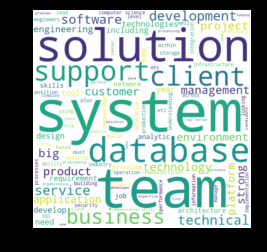

In [37]:
word_cloud(merge_data[merge_data['tag']=='de'], 'FullDescription', stopwords, 'wordcloud_dataengineer.png')

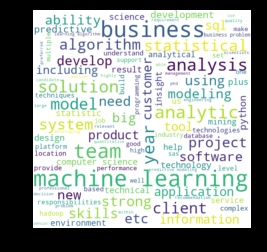

In [38]:
word_cloud(merge_data[merge_data['tag']=='ds'], 'FullDescription', stopwords, 'wordcloud_datascientist.png')

## Skills WordCloud
To identify what skills are assciated with each role

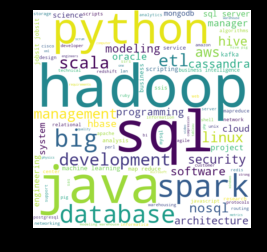

In [39]:
word_cloud(merge_data[merge_data['tag']=='de'], 'Category', stopwords, 'wordcloud_dataengineer_skills.png')

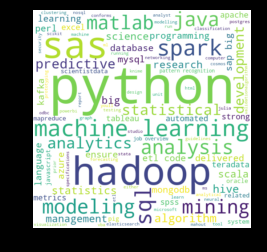

In [40]:
word_cloud(merge_data[merge_data['tag']=='ds'], 'Category', stopwords, 'wordcloud_datascientist_skills.png')